# Using Deep Learning Models to predict stock price movements

(1). We first obtain stock price data from Yahoo. 

(2). We normalize our data and spilt it into training, validation and testing set.

(3). We build a single layer network, multi-layer networks, CNN and LSTM model.

(3). We evaluate the performance by using different statistical measurements.

In [ ]:
# load required packages
import os
import bs4 as bs
import datetime as dt
import requests
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import pickle
from collections import Counter
import scipy.stats as stats
import seaborn as sns
import talib

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, LSTM
from keras.utils import np_utils

import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, r2_score

## (1) Get Data

In [ ]:
def get_data_from_yahoo(ticker):
    
    # specify start date of extracted data
    start = dt.datetime(2000, 1, 1)
    # specify end date of extracted data
    end = dt.datetime.now()

    # extract data
    df = web.DataReader(ticker, 'yahoo', start, end)
    df.reset_index(inplace=True)
    df.set_index("Date", inplace=True)
    
    # uncommnet this if you want to save your data as a csv file
    # df.to_csv(data_path + '{}.csv'.format(ticker))
    return df

In [ ]:
# open file
filename = '/content/drive/My Drive/Research/Machine Learning/data/mydata.p'

with open(filename, mode='rb') as f:
    frames = pickle.load(f)

In [ ]:
for i in range(len(frames)):
  frames[i]['MA10'] = talib.MA(np.array(frames[i]['Close']), timeperiod=10) 
  #frames[i]['EMA10'] = talib.EMA(np.array(frames[i]['Close']), timeperiod=10) 
  frames[i]['MACD'],_,__ = talib.MACD(np.array(frames[i]['Close']),
                              fastperiod=6, slowperiod=12, signalperiod=9) 
  frames[i]['RSI']=talib.RSI(np.array(frames[i]['Close']), timeperiod=12)     #RSI的天数一般是6、12、24
  frames[i]['MOM']=talib.MOM(np.array(frames[i]['Close']), timeperiod=5)
  frames[i] = frames[i].dropna()

In [ ]:
data = frames[0]

for i in range(1,len(frames)):
  data = data.append(frames[i])

## (2). Normalize and split our data into training, validation and testing datasets

In [1]:
def split_dataset(data):
    
    train = data[:-2000]
    validation = data[-2000:-1500]
    test = data[-1500:]
    
    return train, validation, test

def get_label(data, k):
    
    close_price = np.array(data['Close'])
    ret = (close_price[k:] - close_price[:-k]) / close_price[:-k]
    return ret[21:]

# rolling window
def normalization(data, mean, std, k):
    roll_mean = data.rolling(window=21).mean()
    roll_std = data.rolling(window=21).std()
    data_nor = (data - roll_mean) / roll_std

    return np.array(data_nor[21:-k])

In [ ]:
train_nor = []
train_label = []
val_nor = []
val_label = []
test_nor = []
test_label = []

for i in range(len(frames)):
    # we simply split the dataset into three parts.
    # train_data is for model training
    # val_data is for hyperparameter tuning
    # test_data is for final comparison
    temp_stock_index = frames[i]
    temp_train_data, temp_val_data, temp_test_data = split_dataset(temp_stock_index)
    
    # we normalize training data by its mean and standard deviation
    temp_train_nor = normalization(temp_train_data, mean = temp_train_data.mean(), std = temp_train_data.std(), k=1)
    # alpha is the threshold of deciding labels and we can adjust it accordingly
    temp_train_label = get_label(temp_train_data, k=1)
    
    # we do the same for validation and testing datasets
    # however, we can only use mean and standard deviation of training data. 
    # otherwise, we are using future information and it is wrong
    temp_val_nor = normalization(temp_val_data, mean = temp_train_data.mean(), std = temp_train_data.std(), k=1)
    temp_val_label = get_label(temp_val_data, k=1)
    temp_test_nor = normalization(temp_test_data, mean = temp_train_data.mean(), std = temp_train_data.std(), k=1)
    temp_test_label = get_label(temp_test_data, k=1)
    
    train_nor.append(temp_train_nor)
    train_label.append(temp_train_label)
    val_nor.append(temp_val_nor)
    val_label.append(temp_val_label)
    test_nor.append(temp_test_nor)
    test_label.append(temp_test_label)

## (3) Build Networks

In [ ]:
# we now start building different networks
# we use past 50 observations as our inputs
# we need to configure out the input dimensions for different networks as they require different dimensions

def model_data(X, Y, T, method):
    stock_num = len(X)
    
    for k in range(stock_num):
        #print(k)
        temp_X = X[k]
        temp_Y = Y[k]
        
        [N, D] = temp_X.shape
        df = np.array(temp_X)
        dY = np.array(temp_Y)
        temp_dataY = dY[T - 1:N]
        #dataY = np_utils.to_categorical(dataY, 3)

        if method == 'fcn':
            temp_dataX = np.zeros((N - T + 1, T*D))
            for i in range(T, N + 1):
                temp_dataX[i - T] = np.concatenate(df[i - T:i, :])

        if method == 'cnn':
            temp_dataX = np.zeros((N - T + 1, T, D))
            for i in range(T, N + 1):
                temp_dataX[i - T] = df[i - T:i, :]

            temp_dataX = temp_dataX.reshape(temp_dataX.shape + (1,))

        if method == 'lstm':
            temp_dataX = np.zeros((N - T + 1, T, D))
            for i in range(T, N + 1):
                temp_dataX[i - T] = df[i - T:i, :]
        
        if method == 'rf':
            temp_dataX = np.zeros((N - T + 1, T, D))
            for i in range(T, N + 1):
                temp_dataX[i - T] = df[i - T:i, :]
                
        if k == 0:
            dataX = temp_dataX
            dataY = temp_dataY
        else:
            dataX = np.append(dataX, temp_dataX,axis=0)
            dataY = np.append(dataY, temp_dataY,axis=0)    

    return dataX, dataY

### (3.0) A linear model

In [ ]:
# google
train_x_fcn, train_y_fcn = model_data(train_nor, train_label, T=21, method='fcn')
val_x_fcn, val_y_fcn = model_data(val_nor, val_label, T=21, method='fcn')
test_x_fcn, test_y_fcn = model_data(test_nor, test_label, T=21, method='fcn')

print(train_x_fcn.shape, train_y_fcn.shape)

(1015716, 231) (1015716,)


In [1]:
# solve using mle
reg = LinearRegression().fit(train_x_fcn, train_y_fcn)

In [ ]:
pred_y = reg.predict(val_x_fcn)
print('mae:', mean_absolute_error(val_y_fcn, pred_y))

In [ ]:
# solve using gradient descent
clf = linear_model.SGDRegressor(loss='squared_loss', penalty='l2', alpha=0.0005)
train_error = []
valid_error = []

for _ in range(100):
    clf.partial_fit(train_x_fcn, train_y_fcn)
    pred_train_y = clf.predict(train_x_fcn)
    train_error.append(mean_absolute_error(train_y_fcn, pred_train_y))
    
    pred_y = clf.predict(val_x_fcn)
    valid_error.append(mean_absolute_error(val_y_fcn, pred_y))

In [ ]:
valid_error[-1]

0.051465875935961844

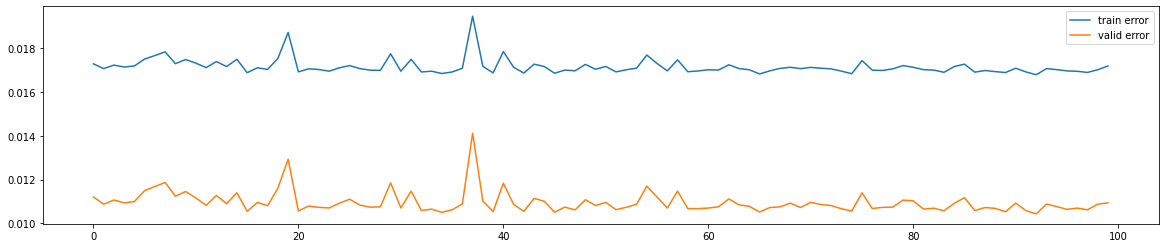

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(train_error, label='train error')
plt.plot(valid_error, label='valid error')
plt.legend()

In [ ]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [ ]:
results = pd.DataFrame({'Model': [], 'Details':[],
                           'Mean Squared Error (MSE)':[],
                           'Mean Absolute Error (MAE)':[],
                           'R-squared':[],
                           'Adjusted R-squared':[]})

In [ ]:
pred_compare = test_y_fcn[:-21]
real_compare = test_y_fcn[21:]

msesm = format(np.sqrt(mean_squared_error(real_compare,pred_compare)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(real_compare,pred_compare)),'.3f') 
rtesm = format(r2_score(real_compare, pred_compare),'.3f')
artesm = format(adjustedR2(r2_score(real_compare, pred_compare),len(real_compare),train_x_fcn.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['Compared model','-',msesm,maesm,rtesm,artesm] 
results

,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,Compared model,-,0.123,0.292,-1.028,-1.029


In [ ]:
pred_clf = clf.predict(test_x_fcn)

msesm = format(np.sqrt(mean_squared_error(test_y_fcn,pred_clf)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_fcn,pred_clf)),'.3f') 
rtesm = format(r2_score(test_y_fcn, pred_clf),'.3f')
artesm = format(adjustedR2(r2_score(test_y_fcn, pred_clf),len(test_y_fcn),train_x_fcn.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['A linear model','-',msesm,maesm,rtesm,artesm] 
results

,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,Long Short Term Memory Model,-,0.088,0.243,-0.049,-0.049
1,Long Short Term Memory Model,-,0.089,0.244,-0.054,-0.054
2,A linear model,-,0.021,0.113,-0.050,-0.050


### (3.1) A single layer network

In [ ]:
def create_single_nn():
    # keras
    model = Sequential()
    # 一层中有128个神经元 要定义input shape
    model.add(Dense(128, activation='tanh', input_shape=(train_x_fcn.shape[1],)))
    # output的一层
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # loss function
    model.compile(loss='mae', optimizer='adam')
    
    return model
    
train_x_fcn, train_y_fcn = model_data(train_nor, train_label, T=21, method='fcn')
val_x_fcn, val_y_fcn = model_data(val_nor, val_label, T=21, method='fcn')
test_x_fcn, test_y_fcn = model_data(test_nor, test_label, T=21, method='fcn')

In [ ]:
print(train_x_fcn.shape)
print(train_y_fcn.shape)
print(train_y_fcn[:5])

(1023066, 231)
(1023066,)
[ 0.0505415  -0.03508011  0.02567143  0.47222216 -0.10691821]


In [ ]:
single_nn = create_single_nn()
single_nn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               29696     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 29,825
Trainable params: 29,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
single_nn.fit(train_x_fcn, train_y_fcn, batch_size=32, 
              validation_data = (val_x_fcn, val_y_fcn),
              epochs=50, verbose=1)

In [ ]:
pred_snn = single_nn.predict(test_x_fcn)

msesm = format(np.sqrt(mean_squared_error(test_y_fcn,pred_snn)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_fcn,pred_snn)),'.3f') 
rtesm = format(r2_score(test_y_fcn, pred_snn),'.3f')
artesm = format(adjustedR2(r2_score(test_y_fcn, pred_snn),len(test_y_fcn),train_x_fcn.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['A single layer network','-',msesm,maesm,rtesm,artesm] 
results

,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,Compared model,-,0.123,0.292,-1.028,-1.029
1,A linear model,-,0.089,0.247,-0.072,-0.072
2,A single layer network,-,0.095,0.258,-0.209,-0.209
3,A single layer network,-,0.089,0.246,-0.066,-0.066


In [ ]:
pred_snn = single_nn.predict(test_x_fcn)

msesm = format(np.sqrt(mean_squared_error(test_y_fcn,pred_snn)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_fcn,pred_snn)),'.3f') 
rtesm = format(r2_score(test_y_fcn, pred_snn),'.3f')
artesm = format(adjustedR2(r2_score(test_y_fcn, pred_snn),len(test_y_fcn),train_x_fcn.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['A single layer network','-',msesm,maesm,rtesm,artesm] 
results

,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,Compared model,-,0.030,0.134,-1.088,-1.090
1,A single layer network,-,0.021,0.112,-0.027,-0.029


### (3.2) A multi-layer network

In [ ]:
def create_multi_nn():
    
    model = Sequential()
    model.add(Dense(64, activation='tanh', input_shape=(train_x_fcn.shape[1],)))
    
    # simply adding layers here, we add two layers here 之后都不同定义inputshape
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.2))
              
    # output layer          
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    return model
    
multi_nn = create_multi_nn()
multi_nn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                14848     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
multi_nn.fit(train_x_fcn, train_y_fcn, batch_size=32, 
              validation_data = (val_x_fcn, val_y_fcn),
              epochs=50, verbose=1)

In [ ]:
pred_mnn = multi_nn.predict(test_x_fcn)

In [ ]:
pred_mnn = multi_nn.predict(test_x_fcn)

msesm = format(np.sqrt(mean_squared_error(test_y_fcn,pred_mnn)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_fcn,pred_mnn)),'.3f') 
rtesm = format(r2_score(test_y_fcn, pred_mnn),'.3f')
artesm = format(adjustedR2(r2_score(test_y_fcn, pred_mnn),len(test_y_fcn),train_x_fcn.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['A multi-layer network','-',msesm,maesm,rtesm,artesm] 
results

,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,Compared model,-,0.123,0.292,-1.028,-1.029
1,A linear model,-,0.089,0.247,-0.072,-0.072
2,A single layer network,-,0.095,0.258,-0.209,-0.209
3,A single layer network,-,0.089,0.246,-0.066,-0.066
4,A multi-layer network,-,0.087,0.240,-0.010,-0.011


In [ ]:
pred_mnn = multi_nn.predict(test_x_fcn)

msesm = format(np.sqrt(mean_squared_error(test_y_fcn,pred_mnn)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_fcn,pred_mnn)),'.3f') 
rtesm = format(r2_score(test_y_fcn, pred_mnn),'.3f')
artesm = format(adjustedR2(r2_score(test_y_fcn, pred_mnn),len(test_y_fcn),train_x_fcn.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['A multi-layer network','-',msesm,maesm,rtesm,artesm] 
results

,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,Compared model,-,0.030,0.134,-1.088,-1.090
1,A multi-layer network,-,0.021,0.111,-0.001,-0.002


In [ ]:
def create_multi_nn():
    
    model = Sequential()
    model.add(Dense(128, activation='tanh', input_shape=(train_x_fcn.shape[1],)))
    
    # simply adding layers here, we add two layers here 之后都不同定义inputshape
    model.add(Dense(128, activation='tanh'))
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.2))
              
    # output layer          
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    return model
    
multi_nn = create_multi_nn()
multi_nn.summary()

In [ ]:
multi_nn.fit(train_x_fcn, train_y_fcn, batch_size=32, 
              validation_data = (val_x_fcn, val_y_fcn),
              epochs=10, verbose=1)

In [ ]:
pred_mnn = multi_nn.predict(test_x_fcn)

msesm = format(np.sqrt(mean_squared_error(test_y_fcn,pred_mnn)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_fcn,pred_mnn)),'.3f') 
rtesm = format(r2_score(test_y_fcn, pred_mnn),'.3f')
artesm = format(adjustedR2(r2_score(test_y_fcn, pred_mnn),len(test_y_fcn),train_x_fcn.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['A multi-layer network','-',msesm,maesm,rtesm,artesm] 
results

### (3.3) A convolutional neural network

In [ ]:
def create_cnn():
    
    model = Sequential()
    model.add(Conv2D(16, (1, 6), activation='tanh', input_shape=(train_x_cnn.shape[1], train_x_cnn.shape[2], 1)))
    
    model.add(Conv2D(32, (4, 1), activation='tanh', padding='same'))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    return model
    
#train_x_cnn, train_y_cnn = model_data(train_nor, train_label, T=21, method='cnn')
#val_x_cnn, val_y_cnn = model_data(val_nor, val_label, T=21, method='cnn')
#test_x_cnn, test_y_cnn = model_data(test_nor, test_label, T=21, method='cnn')

print(train_x_cnn.shape)

(1008716, 21, 11, 1)


In [ ]:
cnn_model = create_cnn()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 21, 6, 16)         112       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 6, 32)         2080      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4032)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                129056    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 131,281
Trainable params: 131,281
Non-trainable params: 0
________________________________________________

In [ ]:
cnn_model.fit(train_x_cnn, train_y_cnn, batch_size=32, 
              validation_data = (val_x_cnn, val_y_cnn),
              epochs=50, verbose=1)

In [ ]:
pred_cnn = cnn_model.predict(test_x_cnn)

msesm = format(np.sqrt(mean_squared_error(test_y_cnn,pred_cnn)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_cnn,pred_cnn)),'.3f') 
rtesm = format(r2_score(test_y_cnn, pred_cnn),'.3f')
artesm = format(adjustedR2(r2_score(test_y_cnn, pred_cnn),len(test_y_cnn),train_x_cnn.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['A convolutional neural network','-',msesm,maesm,rtesm,artesm] 
results

,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,A convolutional neural network,-,0.089,0.245,-0.068,-0.068
1,A convolutional neural network,-,0.087,0.241,-0.009,-0.009


### (3.4) A LSTM network

In [ ]:
def create_lstm():
    
    model = Sequential()
    model.add(LSTM(64, input_shape=(train_x_lstm.shape[1], train_x_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam') # loss function保持统一
    
    return model
    
train_x_lstm, train_y_lstm = model_data(train_nor, train_label, T=21, method='lstm')
val_x_lstm, val_y_lstm = model_data(val_nor, val_label, T=21, method='lstm')
test_x_lstm, test_y_lstm = model_data(test_nor, test_label, T=21, method='lstm')

print(train_x_lstm.shape)

(1008716, 21, 11)


In [ ]:
lstm_model = create_lstm()
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                19456     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit(train_x_lstm, train_y_lstm, batch_size=32, 
              validation_data = (val_x_lstm, val_y_lstm),
              epochs=3, verbose=1)

In [ ]:
pred_lstm = lstm_model.predict(val_x_lstm[:10])

In [ ]:
pred_lstm2 = lstm_model.predict(test_x_lstm)

msesm = format(np.sqrt(mean_squared_error(test_y_lstm,pred_lstm2)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_lstm,pred_lstm2)),'.3f') 
rtesm = format(r2_score(test_y_lstm, pred_lstm2),'.3f')
artesm = format(adjustedR2(r2_score(test_y_lstm, pred_lstm2),len(test_y_lstm),train_x_lstm.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['Long Short Term Memory Model','-',msesm,maesm,rtesm,artesm] 
results

,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,Long Short Term Memory Model,-,0.088,0.243,-0.049,-0.049
1,Long Short Term Memory Model,-,0.089,0.244,-0.054,-0.054


In [ ]:
pred_lstm = lstm_model.predict(test_x_lstm)

msesm = format(np.sqrt(mean_squared_error(test_y_lstm,pred_lstm)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_lstm,pred_lstm)),'.3f') 
rtesm = format(r2_score(test_y_lstm, pred_lstm),'.3f')
artesm = format(adjustedR2(r2_score(test_y_lstm, pred_lstm),len(test_y_lstm),train_x_lstm.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['Long Short Term Memory Model','-',msesm,maesm,rtesm,artesm] 
results

,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,Long Short Term Memory Model,-,0.021,0.112,-0.029,-0.029


## (4). Random Forest

In [ ]:
def get_RF_label(df, k):
    pred = np.sign(df['returns'])
    pred = pred.iloc[k:]
    return pred.astype(int)

In [ ]:
train_nor = []
train_label = []
val_nor = []
val_label = []
test_nor = []
test_label = []

for i in range(len(frames)):
    # we simply split the dataset into three parts.
    # train_data is for model training
    # val_data is for hyperparameter tuning
    # test_data is for final comparison
    temp_stock_index = frames[i]
    temp_train_data, temp_val_data, temp_test_data = split_dataset(temp_stock_index)
    
    # we normalize training data by its mean and standard deviation
    temp_train_nor = normalization(temp_train_data, mean = temp_train_data.mean(), std = temp_train_data.std(), k=1)
    # alpha is the threshold of deciding labels and we can adjust it accordingly
    temp_train_label = get_RF_label(temp_train_data, k=1)
    
    # we do the same for validation and testing datasets
    # however, we can only use mean and standard deviation of training data. 
    # otherwise, we are using future information and it is wrong
    temp_val_nor = normalization(temp_val_data, mean = temp_train_data.mean(), std = temp_train_data.std(), k=1)
    temp_val_label = get_RF_label(temp_val_data, k=1)
    temp_test_nor = normalization(temp_test_data, mean = temp_train_data.mean(), std = temp_train_data.std(), k=1)
    temp_test_label = get_RF_label(temp_test_data, k=1)
    
    train_nor.append(temp_train_nor)
    train_label.append(temp_train_label)
    val_nor.append(temp_val_nor)
    val_label.append(temp_val_label)
    test_nor.append(temp_test_nor)
    test_label.append(temp_test_label)

In [ ]:
train_x_rf, train_y_rf = model_data(train_nor, train_label, T=50, method='fcn')
val_x_rf, val_y_rf = model_data(val_nor, val_label, T=50, method='fcn')
test_x_rf, test_y_rf = model_data(test_nor, test_label, T=50, method='fcn')

print(train_x_rf.shape, train_y_rf.shape)

(991916, 600) (991916,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# training
clf_rf = RandomForestRegressor(n_estimators=10, max_depth=10, verbose=2, n_jobs=-1)
clf_rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=2, warm_start=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
clf_rf.fit(train_x_fcn,train_y_fcn)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 44.3min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=2, warm_start=False)

In [ ]:
pred_rf = clf_rf.predict(test_x_fcn)

msesm = format(np.sqrt(mean_squared_error(test_y_fcn,pred_rf)),'.3f') 
maesm = format(np.sqrt(mean_absolute_error(test_y_fcn,pred_rf)),'.3f') 
rtesm = format(r2_score(test_y_fcn, pred_rf),'.3f')
artesm = format(adjustedR2(r2_score(test_y_fcn, pred_rf),test_x_fcn.shape[0],test_x_fcn.shape[1]),'.3f')

r = results.shape[0]
results.loc[r] = ['Random Forest','-',msesm,maesm,rtesm,artesm] 
results

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


,Model,Details,Mean Squared Error (MSE),Mean Absolute Error (MAE),R-squared,Adjusted R-squared
0,Compared model,-,0.123,0.292,-1.028,-1.029
1,A linear model,-,0.089,0.247,-0.072,-0.072
2,A single layer network,-,0.095,0.258,-0.209,-0.209
3,A single layer network,-,0.089,0.246,-0.066,-0.066
4,A multi-layer network,-,0.087,0.240,-0.010,-0.011
5,Random Forest,-,0.087,0.241,-0.019,-0.019


## (5) Prediction

In [ ]:
pricing_data = pd.DataFrame()

for i in range(len(frames)):
  temp_stock_index = frames[i]
  temp_train_data, temp_val_data, temp_test_data = split_dataset(temp_stock_index)

  temp_test_label = get_label(temp_test_data, k=21)

  temp_test_data = temp_test_data[21:-21]

  temp_test_data['label'] = temp_test_label
  temp_test_data['stock'] = i

  if i == 0:
    pricing_data = temp_test_data[20:]
  else:
    pricing_data = pricing_data.append(temp_test_data[20:])

pricing_data = pd.read_csv('/content/drive/My Drive/Research/Machine Learning/data/pricing_monthly.csv', index_col=0)
pricing_data['pred_snn'] = pred_snn
pricing_data['pred_linear'] = pred_clf
pricing_data['pred_multinn'] = pred_mnn
pricing_data['pred_lstm'] = pred_lstm

pricing_data.to_csv('/content/drive/My Drive/Research/Machine Learning/data/pricing_monthly.csv')